# XGBoost models to predict electricity demand in December 2022

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

import xgboost as xgb

import seaborn as sns

# Creating dataset with relevant features

### ENTSO-E electricity demand data

In [2]:
yr_2016 = pd.read_csv("Total Load - Day Ahead _ Actual_201601010000-201701010000.csv")
yr_2017 = pd.read_csv("Total Load - Day Ahead _ Actual_201701010000-201801010000.csv")
yr_2018 = pd.read_csv("Total Load - Day Ahead _ Actual_201801010000-201901010000.csv")
yr_2019 = pd.read_csv("Total Load - Day Ahead _ Actual_201901010000-202001010000.csv")
yr_2020 = pd.read_csv("Total Load - Day Ahead _ Actual_202001010000-202101010000.csv")
yr_2021 = pd.read_csv("Total Load - Day Ahead _ Actual_202101010000-202201010000.csv")
yr_2022 = pd.read_csv("Total Load - Day Ahead _ Actual_202201010000-202301010000.csv")

demand_dataframes=(yr_2016, yr_2017, yr_2018, yr_2019, yr_2020, yr_2021, yr_2022)

demand_2016_2022=pd.DataFrame()
#Converts dataframes to datetime files and adding them to get one single dataframe.
for dataframe in demand_dataframes:
    dataframe.index=pd.to_datetime(dataframe.iloc[:,0].str.split(" - ").str[0], dayfirst=True)
    demand_2016_2022 = pd.concat([demand_2016_2022, dataframe], ignore_index=False)
    
#deleting unnecessary columns
demand_2016_2022=demand_2016_2022.drop(["Day-ahead Total Load Forecast [MW] - BZN|NO1"], axis=1)
demand_2016_2022=demand_2016_2022.drop(["Time (CET/CEST)"], axis=1)

#24 NaN values, so I replace them using forward fill.
demand_2016_2022["Actual Total Load [MW] - BZN|NO1"].isna().sum()
demand_2016_2022["Actual Total Load [MW] - BZN|NO1"].fillna(method='ffill', inplace=True)
demand_2016_2022

#there are seven too many rows in the dataframe, so I check for duplicates.
duplicate_indices = demand_2016_2022.index.duplicated(keep=False)
#print(demand_2016_2022[duplicate_indices])

#deleting duplicates
demand_2016_2022 = demand_2016_2022[~demand_2016_2022.index.duplicated(keep='last')]

## Temperature and precipitation data
Norsk KlimaServiceSenter (https://seklima.met.no/)

In [3]:
weather=pd.read_csv("Temperature and rain 2016-2022.csv", sep=';')

#deleting the two last columns
weather=weather[:-2]

weather["Lufttemperatur"] = weather["Lufttemperatur"].str.replace(',', '.').astype(float)
weather["Nedbør (1 t)"] = pd.to_numeric(weather["Nedbør (1 t)"].str.replace(',', '.'), errors='coerce')


#checking for NaN values
weather["Lufttemperatur"].isna().sum() #0 values
weather["Nedbør (1 t)"].isna().sum() #1 value
weather["Nedbør (1 t)"] = weather["Nedbør (1 t)"].interpolate()

#Changes dataframe index to datetime
weather.index=pd.to_datetime(weather.iloc[:,2], dayfirst=True)
weather = weather.rename_axis("Time (CET/CEST)")
weather=weather.drop(["Navn","Stasjon", "Tid(norsk normaltid)"], axis=1)

## Creates one common dataframe with both electricity demand and weather data 

In [4]:
inf_dataframe=pd.read_csv("inflasjon2015_2022.csv")
inf_dataframe.index=inf_dataframe["time"]
inf_dataframe = inf_dataframe.rename_axis("Time (CET/CEST)")
inf_dataframe = inf_dataframe.drop(["time"], axis=1)
inf_dataframe.index=pd.to_datetime(inf_dataframe.index)

In [5]:
feature_dataframe = pd.merge(weather, demand_2016_2022, on="Time (CET/CEST)")
feature_dataframe.to_csv('feature_dataframe.tsv', sep='\t', index=False)

In [6]:
feature_dataframe['hour'] = feature_dataframe.index.hour
feature_dataframe['day_of_week'] = feature_dataframe.index.dayofweek + 1 #such that monday is 1 rather than 0
feature_dataframe['month'] = feature_dataframe.index.month
feature_dataframe['year'] = feature_dataframe.index.year
feature_dataframe

,Lufttemperatur,Nedbør (1 t),Actual Total Load [MW] - BZN|NO1,hour,day_of_week,month,year
Time (CET/CEST),,,,,,,
2016-01-01 00:00:00,1.1,0.1,4582.0,0,5,1,2016
2016-01-01 01:00:00,1.1,0.3,4482.0,1,5,1,2016
2016-01-01 02:00:00,1.1,0.6,4421.0,2,5,1,2016
2016-01-01 03:00:00,0.9,0.9,4335.0,3,5,1,2016
2016-01-01 04:00:00,1.2,0.4,4304.0,4,5,1,2016
...,...,...,...,...,...,...,...
2022-12-31 19:00:00,0.9,0.0,4824.0,19,6,12,2022
2022-12-31 20:00:00,0.2,0.0,4650.0,20,6,12,2022
2022-12-31 21:00:00,-1.0,0.0,4573.0,21,6,12,2022


#### Splitting feature variables from target

In [7]:
X = feature_dataframe.drop('Actual Total Load [MW] - BZN|NO1', axis=1)
y = feature_dataframe['Actual Total Load [MW] - BZN|NO1']

In [8]:
#fig, ax = plt.subplots(figsize=(10, 8))
#sns.boxplot(data=feature_dataframe, x='month', y='Actual Total Load [MW] - BZN|NO1')
#ax.set_title('average MW by Hour')
#plt.show()

In [9]:
#Empty dataframe
df = pd.DataFrame()

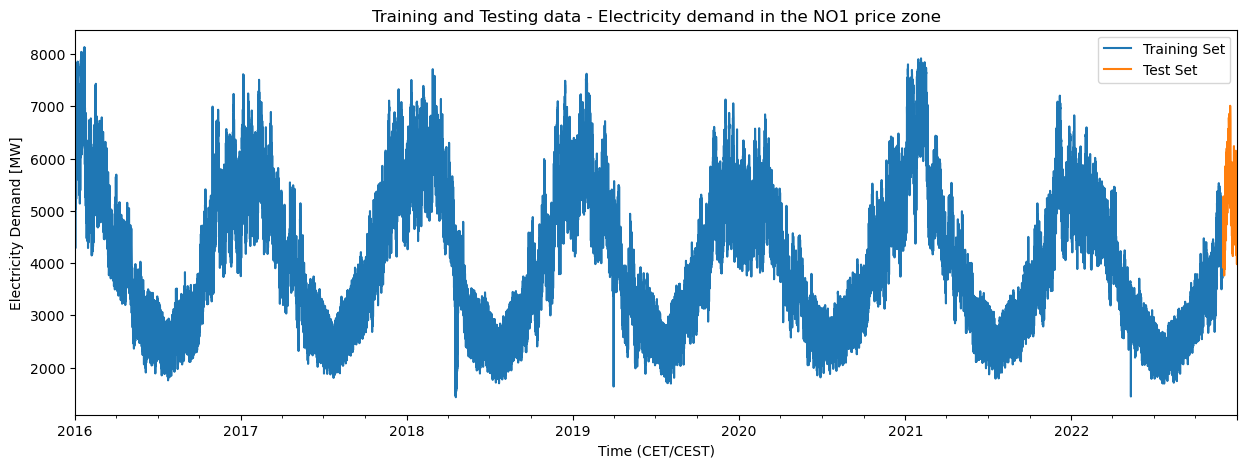

In [41]:
#creates a dataframe that contains all the features. Useful when trying different amounts of data
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['temperature'] = df["Lufttemperatur"]
    df['precipitation'] = df["Nedbør (1 t)"]
    return df
df = create_features(feature_dataframe)

#defines cutoff date for training and testing set
train = feature_dataframe.loc[df.index < '12-01-2022']
test = feature_dataframe.loc[df.index >= '12-01-2022']

train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'day_of_week', 'month', 'year', 'Lufttemperatur', 'Nedbør (1 t)']
TARGET = 'Actual Total Load [MW] - BZN|NO1'


X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

fig, ax = plt.subplots(figsize=(15, 5))
train["Actual Total Load [MW] - BZN|NO1"].plot(label='Training Set')
test["Actual Total Load [MW] - BZN|NO1"].plot(label='Test Set')
ax.set_title("Training and Testing data - Electricity demand in the NO1 price zone")
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel("Electricity Demand [MW]")
fig.savefig("dataset.png")
plt.show()

## Feature correlation and importance

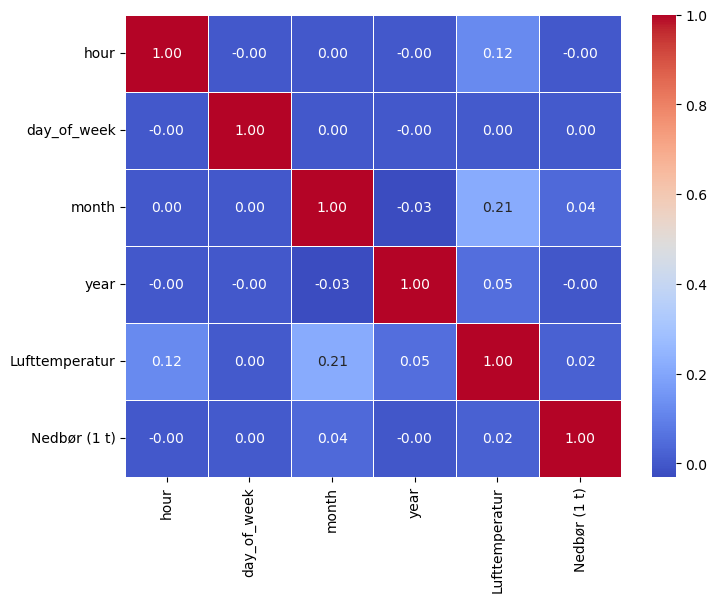

In [17]:
correlation_matrix=X_train.corr()
plt.figure(figsize=(8, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.savefig("correlation.png")
plt.show()

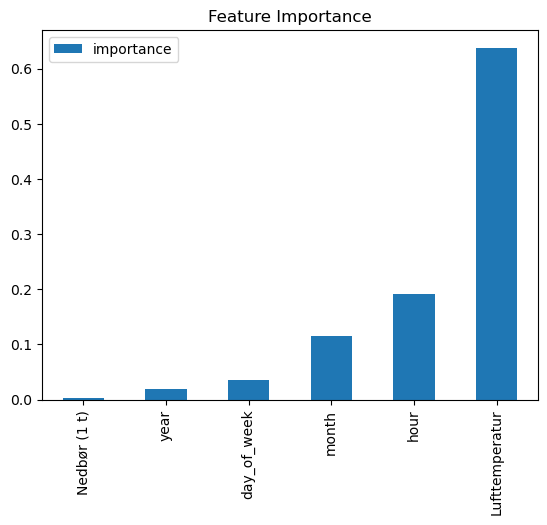

In [20]:
#Feature importance according to first trial of XGBoost model.
importance = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
importance.sort_values('importance').plot(kind='bar', title='Feature Importance')
plt.show()

### Tries XGBoost on the whole dataset before tuning parameters

In [19]:
reg = xgb.XGBRegressor(base_score=y_train.mean(), booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',  
                       max_depth=3,
                       learning_rate=0.1,
                       random_state=123)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1224.72923	validation_1-rmse:1309.77328
[100]	validation_0-rmse:252.36331	validation_1-rmse:314.89774
[200]	validation_0-rmse:235.59749	validation_1-rmse:284.61779
[300]	validation_0-rmse:229.69317	validation_1-rmse:266.19932
[400]	validation_0-rmse:226.10776	validation_1-rmse:258.56276
[500]	validation_0-rmse:222.34673	validation_1-rmse:255.40754
[600]	validation_0-rmse:220.22382	validation_1-rmse:262.83918
[700]	validation_0-rmse:218.43596	validation_1-rmse:261.13412
[800]	validation_0-rmse:216.69704	validation_1-rmse:254.59499
[900]	validation_0-rmse:215.45775	validation_1-rmse:250.18286
[999]	validation_0-rmse:214.24774	validation_1-rmse:245.80436


XGBRegressor(base_score=4044.631960939562, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=500,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

---------

# Parameter tuning
### Parameters to tune are:
- Learning rate
- Regularization parameter L2 (RIDGE)
- Regularization parameter L1 (LASSO)
- Maximum tree depth
- Gamma (minimum loss reduction required to split a branch. functions a bit like a regulatization parameter to prevent overfitting)
- N_estimators (Number of gradient boosted trees)

##### other possible parameters to tune:
- min_child_weight

---------

## Seaborn heatplots for tuning hyperparameters - not used in report

### Max depth vs. learning rate

In [ ]:
np.random.seed(123) #random seed necessary for XGBoost??

max_depth_values = range(1, 10)
learning_rate_values = np.array([0.001, 0.01, 0.1, 1])

results_df = pd.DataFrame(index=max_depth_values, columns=learning_rate_values)

for max_depth in max_depth_values:
    for learning_rate in learning_rate_values:
        reg = xgb.XGBRegressor(
            base_score=y_train.mean(),
            booster='gbtree',
            reg_lambda=0,
            n_estimators=100,
            early_stopping_rounds=500,
            objective='reg:squarederror',  
            max_depth=max_depth,
            learning_rate=learning_rate,
            random_state=123 
        )

        reg.set_params(eval_metric='rmse')

        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=False)

        rmse = reg.evals_result()['validation_1']['rmse'][-1]

        results_df.at[max_depth, learning_rate] = rmse

results_df = results_df.apply(pd.to_numeric)

plt.figure(figsize=(10, 8))
sns.heatmap(results_df, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Testing RMSE'})
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')
plt.title('RMSE Heatmap for Different max_depth and learning_rate Values')
plt.show()

### Regularization parameter (Lambda) vs. learning rate

nb! alpha (LASSO) regression also possible

In [ ]:
np.random.seed(123)

learning_rate_values = np.array([0.001, 0.01, 0.1, 1])
lambda_values = np.array([0, 0.001, 0.01, 0.1, 1])

results_df = pd.DataFrame(index=learning_rate_values, columns=lambda_values)

for learning_rate in learning_rate_values:
    for lambda_val in lambda_values:
        reg = xgb.XGBRegressor(
            base_score=y_train.mean(),
            booster='gbtree',
            max_depth=6, 
            n_estimators=100,
            early_stopping_rounds=500,
            objective='reg:squarederror',
            learning_rate=learning_rate,
            reg_lambda=lambda_val,
            random_state=123
        )

        reg.set_params(eval_metric='rmse')

        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=False)

        rmse = reg.evals_result()['validation_1']['rmse'][-1]

        results_df.at[learning_rate, lambda_val] = rmse

results_df = results_df.apply(pd.to_numeric)

plt.figure(figsize=(10, 8))
sns.heatmap(results_df.T, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Testing RMSE'})
plt.xlabel('Learning Rate')
plt.ylabel('Lambda')
plt.title('RMSE Heatmap for Different Learning Rates and Lambdas')
plt.show()

### Lambda vs. gamma
might be redundant to use both of them?? given that both aim to reduce overfitting

In [ ]:
np.random.seed(123)

gamma_values = np.array([0, 0.1, 2, 30, 4000])
trees_values = np.array([50, 100, 500, 1000, 2000])

results_df = pd.DataFrame(index=gamma_values, columns=trees_values)

for gamma_val in gamma_values:
    for trees_value in trees_values:
        reg = xgb.XGBRegressor(
            base_score=y_train_mean(),
            booster='gbtree',
            max_depth=6,  
            n_estimators=trees_value,
            early_stopping_rounds=500,
            objective='reg:squarederror',
            gamma=gamma_val,
            learning_rate=0.1,
            reg_lambda=0.0,
            random_state=123
        )

        reg.set_params(eval_metric='rmse')

        reg.fit(X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=False)

        rmse = reg.evals_result()['validation_1']['rmse'][-1]

        results_df.at[gamma_val, trees_value] = rmse

results_df = results_df.apply(pd.to_numeric)

plt.figure(figsize=(10, 8))
sns.heatmap(results_df.T, annot=True, fmt=".4f", cmap="viridis", cbar_kws={'label': 'Testing RMSE'})
plt.xlabel('Gamma')
plt.ylabel('n_estimators')
plt.title('RMSE Heatmap for Different Gamma and n_estimators')
plt.show()

In [ ]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test['error'].sort_values(ascending=False)#.head(10)

In [ ]:
test['prediction'] = reg.predict(X_test)
df = feature_dataframe.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df_pred=df.loc[df.index >= '12-01-2022']
ax = df_pred[['Actual Total Load [MW] - BZN|NO1']].plot(figsize=(15, 5))
df_pred['prediction'].plot(ax=ax, style='.')
plt.legend(['True Values', 'Predictions'])
ax.set_title('True Demand Values vs. Prediction')
plt.show()

### Check for autocorrelation?
Autocorrelation every 7 days? Maybe 7 days is enough as a lookback period?

### Check for different amounts of data
#### six years, two years, one year, one month, one week

In [21]:
X_train_tot = X_train ; y_train_tot = y_train #total dataset from 2016-2022 minus last month as test set.
X_train_year = X_train.loc[X_train.index >= '12-01-2021'] ; y_train_year = y_train.loc[y_train.index >= '12-01-2021'] #only the year of 2022
X_train_month = X_train.loc[X_train.index >= '11-01-2022'] ; y_train_month = y_train.loc[y_train.index >= '11-01-2022'] #only November 2022
X_train_twoyears = X_train.loc[X_train.index >= '01-01-2021'] ; y_train_twoyears = y_train.loc[y_train.index >= '01-01-2021'] #only the year of 2022
X_train_week = X_train.loc[X_train.index >= '11-24-2022'] ; y_train_week = y_train.loc[y_train.index >= '11-24-2022'] #only November 2022
X_train_fouryears = X_train.loc[X_train.index >= '01-01-2019'] ; y_train_fouryears = y_train.loc[y_train.index >= '01-01-2019'] #only the year of 2022

# Finds optimal hyperparameters using sklearn gridsearch
## For six different training datasets: Six years, four years, two years, one year, one month and one week. Not all of them are used in report

## Six years of training data

In [38]:
# Define the parameters included in the grid search
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 8,10],
    'n_estimators': [50, 100, 200, 1000],
    'gamma': [0, 0.1,0.5,1,10],
    'learning_rate': [0.001,0.01, 0.1, 0.2],
    'reg_lambda': [0.0, 0.001, 0.01, 0.1],
    'reg_alpha': [0.0, 0.001, 0.01, 0.1]
}
#trains the  model
reg = xgb.XGBRegressor(
    base_score=y_train_tot.mean(),
    booster='gbtree',
    objective='reg:squarederror',
    random_state=123
)

grid_search = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,  # 5-fold cross-validation
    verbose=2, #to generate more output information when running the code.
    n_jobs=-1 #parallel processing to hopefully reduce computational time
)

grid_search.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=500, verbose=100) #verbose=100 to print rmse for every 100 boosting rounds

# Get the best parameters from the grid search
optimal_params = grid_search.best_params_
print("optimal Hyperparameters:", optimal_params)

# Get the best model from the grid search
optimal_parameters = grid_search.best_estimator_

# print prediction with the optimal hyperparameters from the grid search
y_pred = optimal_parameters.predict(X_test)

# Test set RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False) #Squared=False gives the RMSE instead of the MSE
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)

Fitting 5 folds for each of 8960 candidates, totalling 44800 fits


KeyboardInterrupt: 

[0]	validation_0-rmse:1320.66415	validation_1-rmse:1443.81560


C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[100]	validation_0-rmse:603.78918	validation_1-rmse:425.15810
[200]	validation_0-rmse:363.12207	validation_1-rmse:275.32404
[300]	validation_0-rmse:280.69316	validation_1-rmse:258.76320
[400]	validation_0-rmse:251.43309	validation_1-rmse:250.67803
[500]	validation_0-rmse:238.26099	validation_1-rmse:241.19276
[600]	validation_0-rmse:231.77742	validation_1-rmse:235.54931
[700]	validation_0-rmse:227.65225	validation_1-rmse:233.74526
[800]	validation_0-rmse:224.84748	validation_1-rmse:232.64358
[900]	validation_0-rmse:222.72467	validation_1-rmse:231.26098
[999]	validation_0-rmse:220.40230	validation_1-rmse:230.86293


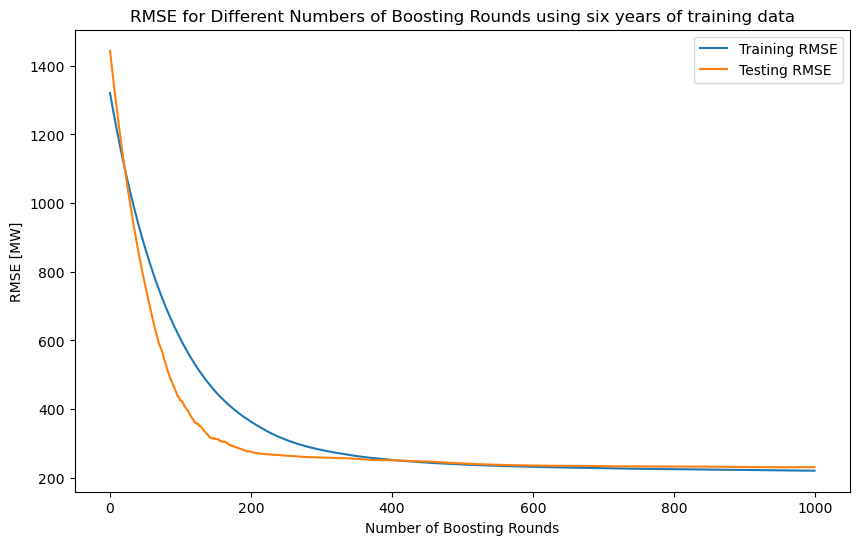

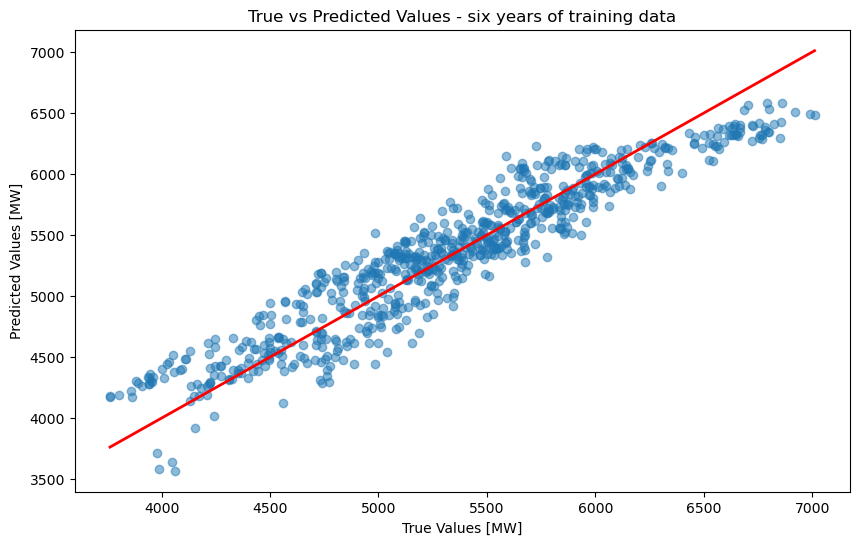

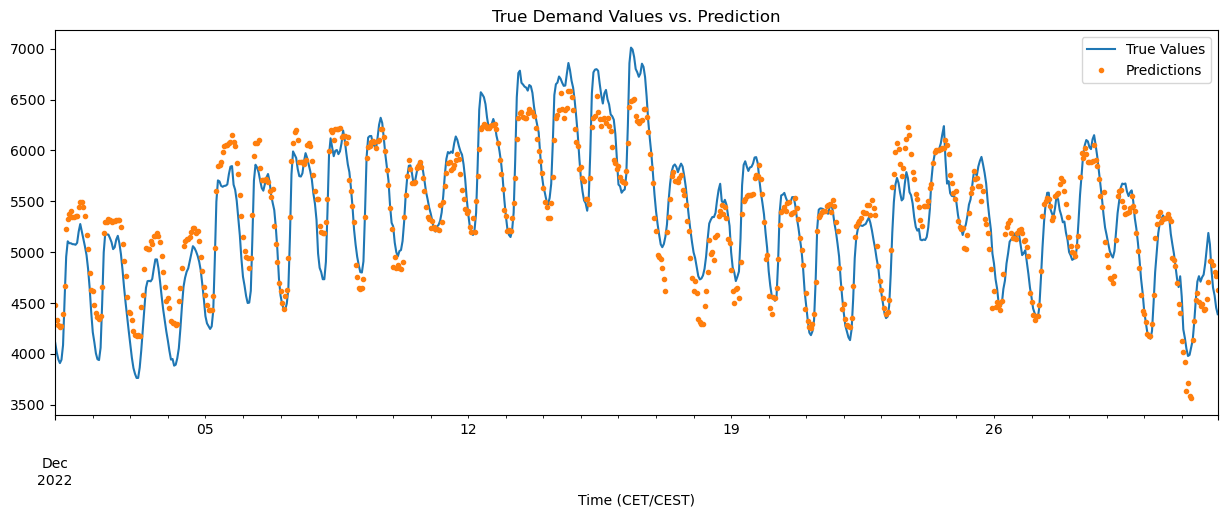

In [24]:
reg_tot = xgb.XGBRegressor(base_score=y_train_tot.mean(), booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',  
                       max_depth=5,
                       learning_rate=0.01,
                       reg_alpha=0.1,
                       reg_lambda=0.01,
                       gamma=0,
                       random_state=123)

results = reg_tot.fit(X_train_tot, y_train_tot,
                      eval_set=[(X_train_tot, y_train_tot), (X_test, y_test)],
                      eval_metric="rmse",  
                      verbose=100)

# Making predictions on the test set
y_pred_tot = reg_tot.predict(X_test)

# Extracting training and testing RMSE from the results
training_rmse_tot = results.evals_result()['validation_0']['rmse']
testing_rmse_tot = results.evals_result()['validation_1']['rmse']

# Plotting RMSE convergence
plt.figure(figsize=(10, 6))
plt.plot(training_rmse_tot, label='Training RMSE')
plt.plot(testing_rmse_tot, label='Testing RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE [MW]')
plt.title('RMSE for Different Numbers of Boosting Rounds using six years of training data')
plt.legend()

# Plotting true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_tot, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '-', color='red', linewidth=2)
plt.xlabel('True Values [MW]')
plt.ylabel('Predicted Values [MW]')
plt.title('True vs Predicted Values - six years of training data')
plt.savefig('accuracies_tot.png')
plt.show()

# Plotting true vs predicted values as timeseries
test['prediction'] = y_pred_tot
df = feature_dataframe.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df_pred=df.loc[df.index >= '12-01-2022']
ax = df_pred[['Actual Total Load [MW] - BZN|NO1']].plot(figsize=(15, 5))
df_pred['prediction'].plot(ax=ax, style='.')
plt.legend(['True Values', 'Predictions'])
ax.set_title('True Demand Values vs. Prediction')
plt.savefig('accuracies_tot_time.png')
plt.show()

## One year of training data

In [ ]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 8,10],
    'n_estimators': [50, 100, 200, 1000],
    'gamma': [0, 0.1,0.5,1,10],
    'learning_rate': [0.001,0.01, 0.1, 0.2],
    'reg_lambda': [0.0, 0.001, 0.01, 0.1],
    'reg_alpha': [0.0, 0.001, 0.01, 0.1]
}

reg = xgb.XGBRegressor(
    base_score=y_train_year.mean(),
    booster='gbtree',
    objective='reg:squarederror',
    random_state=123
)

grid_search = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5, 
    verbose=2,
    n_jobs=-1  
)

grid_search.fit(X_train_year, y_train_year, eval_set=[(X_test, y_test)], early_stopping_rounds=500, verbose=100)

optimal_params = grid_search.best_params_
print("Optimal Hyperparameters:", optimal_params)

optimal_model = grid_search.best_estimator_

y_pred = optimal_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)

[0]	validation_0-rmse:1114.57662	validation_1-rmse:1630.67034
[100]	validation_0-rmse:230.88187	validation_1-rmse:330.36272
[200]	validation_0-rmse:200.91915	validation_1-rmse:322.20161


C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[300]	validation_0-rmse:192.46227	validation_1-rmse:321.52693
[400]	validation_0-rmse:187.47070	validation_1-rmse:322.72910
[500]	validation_0-rmse:184.75799	validation_1-rmse:322.12882
[600]	validation_0-rmse:182.87300	validation_1-rmse:321.89521
[686]	validation_0-rmse:181.30295	validation_1-rmse:321.88467


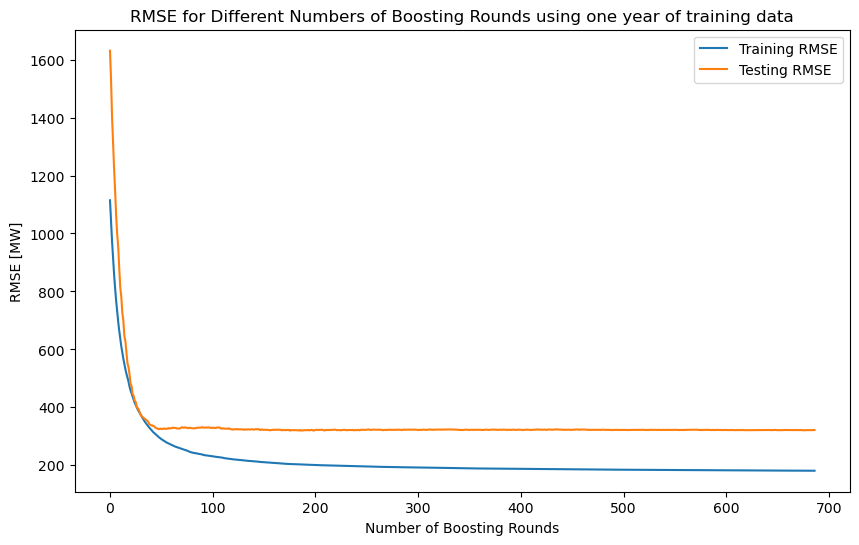

In [28]:
reg_year = xgb.XGBRegressor(base_score=y_train_year.mean(), booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',  
                       max_depth=2,
                       learning_rate=0.1,
                       reg_alpha=0.1,
                       reg_lambda=0.1,
                       gamma=0,
                       random_state=123)


results = reg_year.fit(X_train_year, y_train_year,
                       eval_set=[(X_train_year, y_train_year), (X_test, y_test)],
                       eval_metric="rmse",  
                       verbose=100)

training_rmse_year = results.evals_result()['validation_0']['rmse']
testing_rmse_year = results.evals_result()['validation_1']['rmse']

y_pred_year = reg_year.predict(X_test)

plt.figure(figsize=(10, 6))
plt.plot(training_rmse_year, label='Training RMSE')
plt.plot(testing_rmse_year, label='Testing RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE [MW]')
plt.title('RMSE for Different Numbers of Boosting Rounds using one year of training data')
plt.legend()
plt.show()



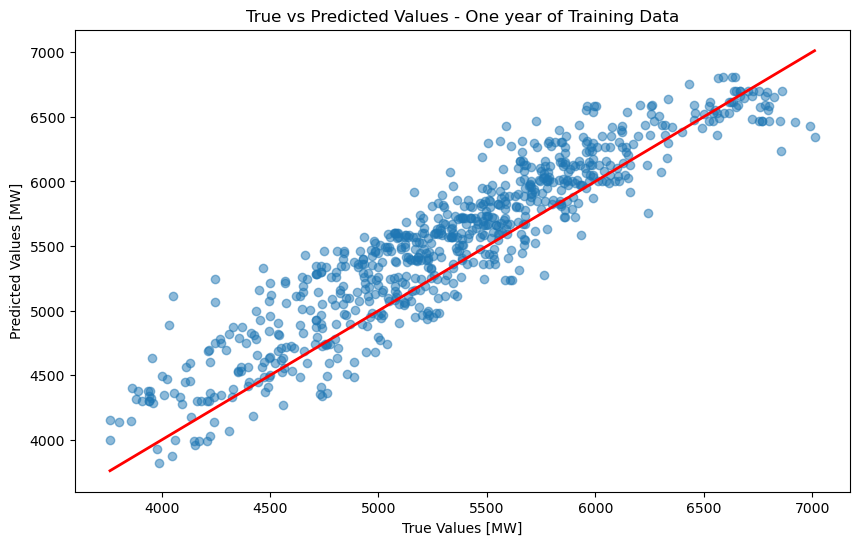

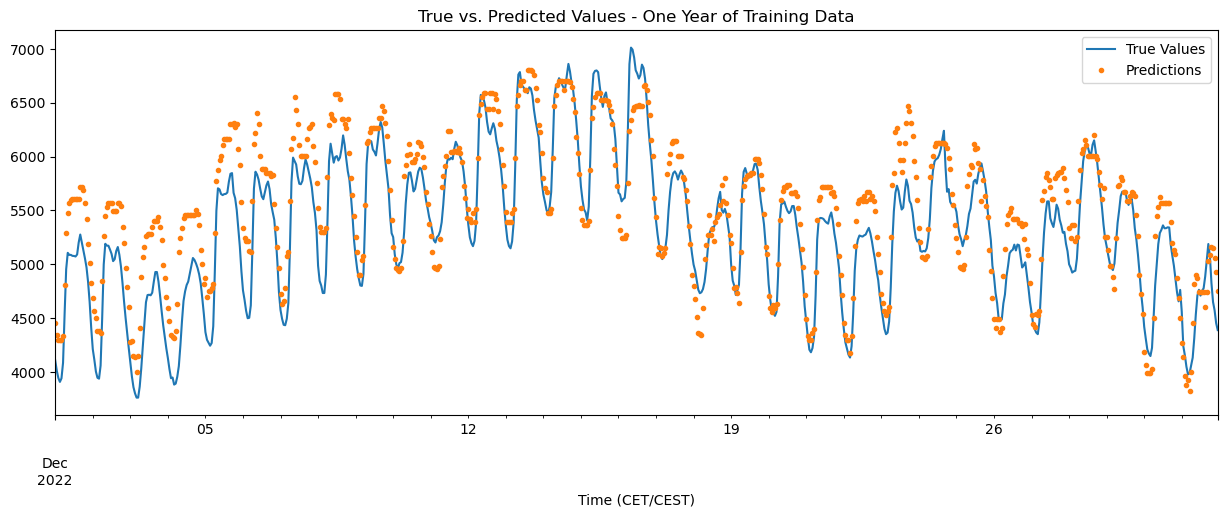

In [29]:
# Plotting true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_year, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '-', color='red', linewidth=2)
plt.xlabel('True Values [MW]')
plt.ylabel('Predicted Values [MW]')
plt.title('True vs Predicted Values - One year of Training Data')
plt.savefig('accuracies_year.png')
plt.show()

test['prediction'] = y_pred_year
df = feature_dataframe.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df_pred=df.loc[df.index >= '12-01-2022']
ax = df_pred[['Actual Total Load [MW] - BZN|NO1']].plot(figsize=(15, 5))
df_pred['prediction'].plot(ax=ax, style='.')
plt.legend(['True Values', 'Predictions'])
ax.set_title('True vs. Predicted Values - One Year of Training Data')
plt.savefig('accuracies_year_time.png')
plt.show()

## One month of training data

In [ ]:
# Define the parameter grid for grid search
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 8,10],
    'n_estimators': [50, 100, 200, 1000],
    'gamma': [0, 0.1,0.5,1,10],
    'learning_rate': [0.001,0.01, 0.1, 0.2],
    'reg_lambda': [0.0, 0.001, 0.01, 0.1],
    'reg_alpha': [0.0, 0.001, 0.01, 0.1]
}

# Create XGBRegressor
reg = xgb.XGBRegressor(
    base_score=y_train_month.mean(),
    booster='gbtree',
    objective='reg:squarederror',
    random_state=123
)

# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,  
    verbose=2,
    n_jobs=-1 
)

grid_search.fit(X_train_month, y_train_month, eval_set=[(X_test, y_test)], early_stopping_rounds=500, verbose=100)

optimal_params = grid_search.best_params_
print("optimal Hyperparameters:", optimal_params)

optimal_model = grid_search.best_estimator_

y_pred = optimal_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)

[0]	validation_0-rmse:591.95022	validation_1-rmse:1257.87984
[100]	validation_0-rmse:116.83281	validation_1-rmse:706.67715


C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[199]	validation_0-rmse:99.14695	validation_1-rmse:659.48637


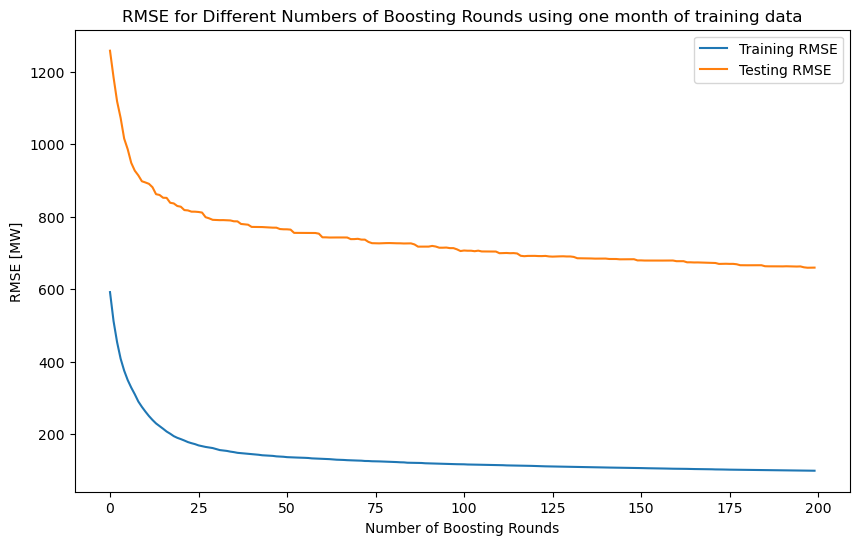

In [36]:
# Define the parameter found in the grid search
reg_month = xgb.XGBRegressor(base_score=y_train_month.mean(), booster='gbtree',    
                       n_estimators=200,
                       early_stopping_rounds=500,
                       objective='reg:squarederror', 
                       max_depth=2,
                       learning_rate=0.2,
                       reg_alpha=0.1,
                       reg_lambda=0.001,
                       gamma=0,
                       random_state=123)


results = reg_month.fit(X_train_month, y_train_month,
                       eval_set=[(X_train_month, y_train_month), (X_test, y_test)],
                       eval_metric="rmse",  
                       verbose=100)

training_rmse_month = results.evals_result()['validation_0']['rmse']
testing_rmse_month = results.evals_result()['validation_1']['rmse']

y_pred_month = reg_month.predict(X_test)


plt.figure(figsize=(10, 6))
plt.plot(training_rmse_month, label='Training RMSE')
plt.plot(testing_rmse_month, label='Testing RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE [MW]')
plt.title('RMSE for Different Numbers of Boosting Rounds using one month of training data')
plt.legend()
plt.show()




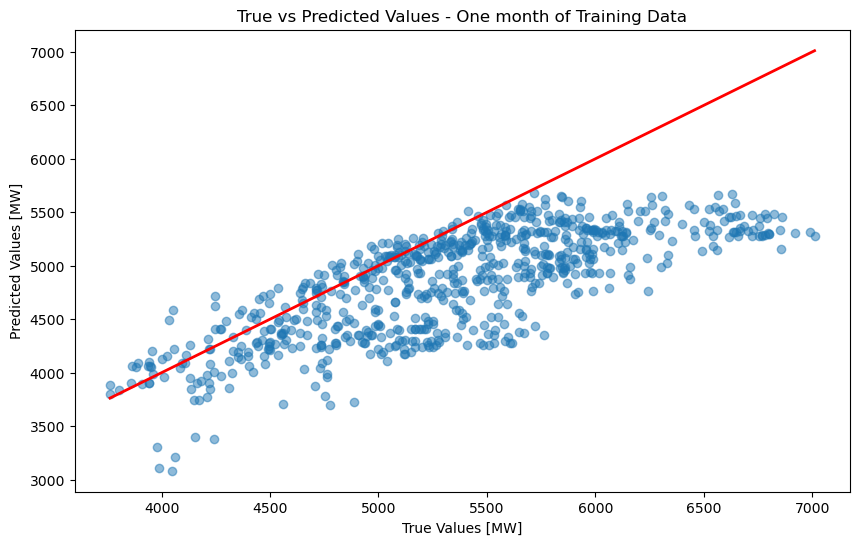

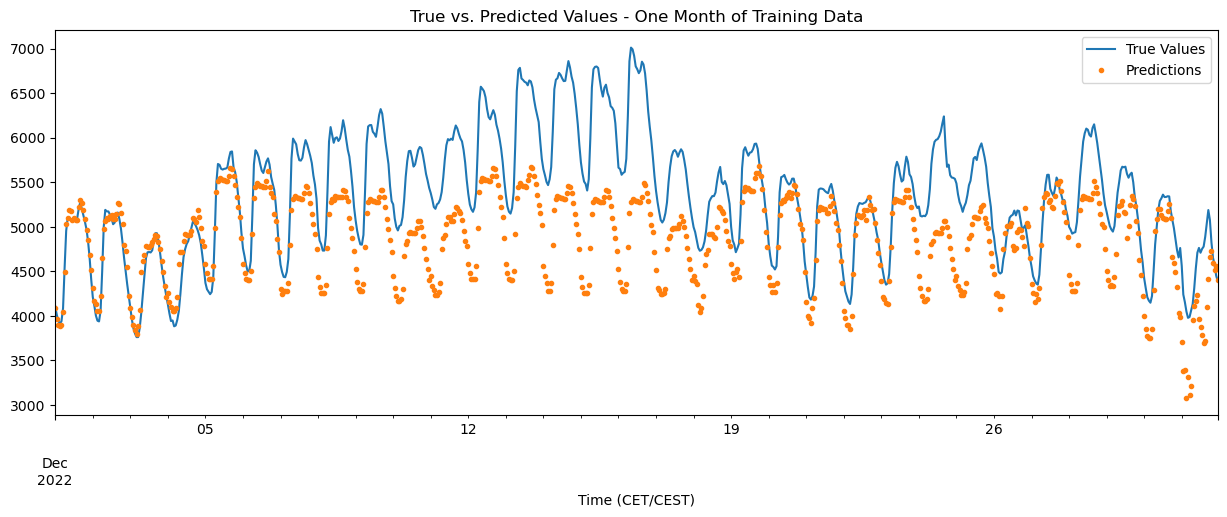

In [37]:
# Plotting true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_month, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '-', color='red', linewidth=2)
plt.xlabel('True Values [MW]')
plt.ylabel('Predicted Values [MW]')
plt.title('True vs Predicted Values - One month of Training Data')
plt.savefig('accuracies_month.png')
plt.show()

test['prediction'] = y_pred_month
df = feature_dataframe.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df_pred=df.loc[df.index >= '12-01-2022']
ax = df_pred[['Actual Total Load [MW] - BZN|NO1']].plot(figsize=(15, 5))
df_pred['prediction'].plot(ax=ax, style='.')
plt.legend(['True Values', 'Predictions'])
ax.set_title('True vs. Predicted Values - One Month of Training Data')
plt.savefig('accuracies_month_time.png')
plt.show()

## 1 Week of training data

In [ ]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 8,10],
    'n_estimators': [50, 100, 200, 1000],
    'gamma': [0, 0.1,0.5,1,10],
    'learning_rate': [0.001,0.01, 0.1, 0.2],
    'reg_lambda': [0.0, 0.001, 0.01, 0.1],
    'reg_alpha': [0.0, 0.001, 0.01, 0.1]
}

reg = xgb.XGBRegressor(
    base_score=y_train_week.mean(),
    booster='gbtree',
    objective='reg:squarederror',
    random_state=123
)

grid_search = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,  
    verbose=2,
    n_jobs=-1  
)

grid_search.fit(X_train_month, y_train_month, eval_set=[(X_test, y_test)], early_stopping_rounds=500, verbose=100)

optimal_params = grid_search.best_params_
print("Optimal Hyperparameters:", optimal_params)

optimal_model = grid_search.best_estimator_

y_pred = optimal_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)


[0]	validation_0-rmse:473.05800	validation_1-rmse:1068.82184
[100]	validation_0-rmse:60.93936	validation_1-rmse:871.76753
[200]	validation_0-rmse:44.93619	validation_1-rmse:866.46581
[300]	validation_0-rmse:38.53813	validation_1-rmse:871.32831
[400]	validation_0-rmse:34.81854	validation_1-rmse:872.78061


C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[500]	validation_0-rmse:32.25249	validation_1-rmse:876.22467
[600]	validation_0-rmse:30.32241	validation_1-rmse:875.65642
[700]	validation_0-rmse:28.41766	validation_1-rmse:874.14066
[720]	validation_0-rmse:28.07152	validation_1-rmse:874.58936


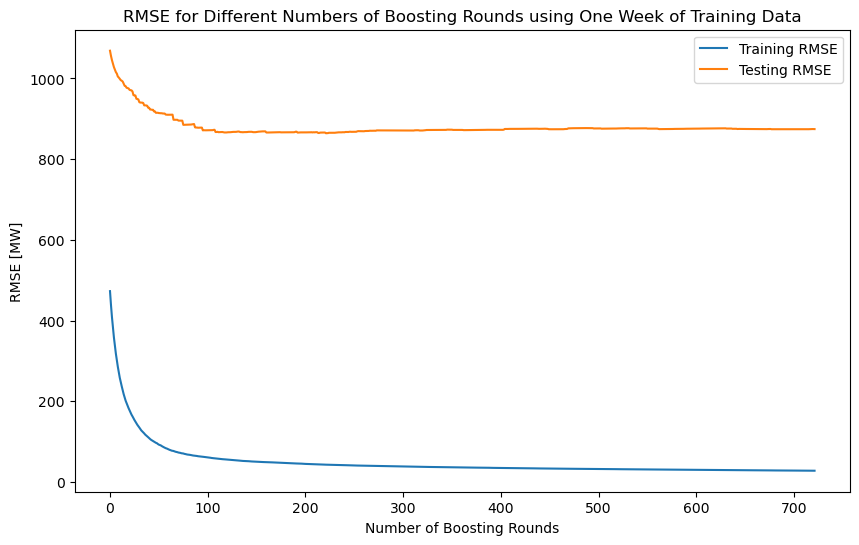

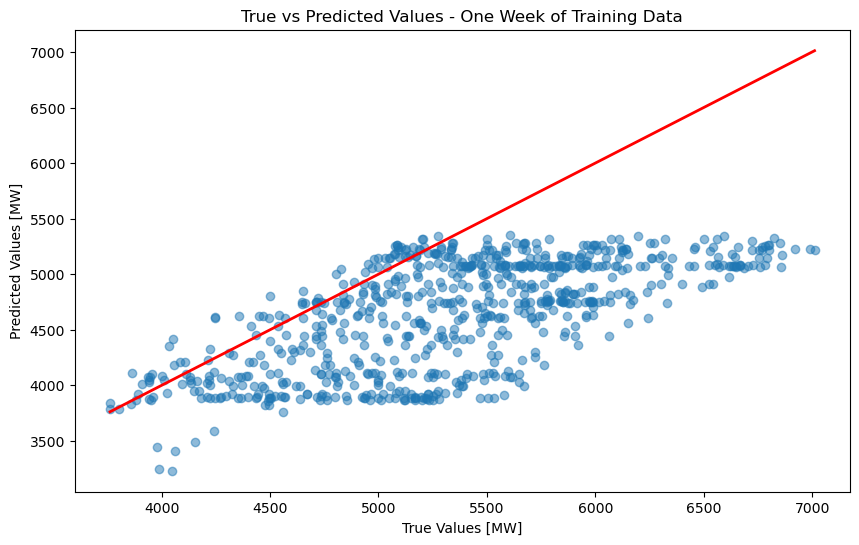

In [34]:
reg_week = xgb.XGBRegressor(base_score=y_train_week.mean(), booster='gbtree',    
                            n_estimators=1000,
                            early_stopping_rounds=500,
                            objective='reg:squarederror', 
                            max_depth=2,
                            learning_rate=0.1,
                            reg_alpha=0.001,
                            reg_lambda=0.001,
                            gamma=0,
                            random_state=123)

results_week = reg_week.fit(X_train_week, y_train_week,
                            eval_set=[(X_train_week, y_train_week), (X_test, y_test)],
                            eval_metric="rmse", 
                            verbose=100)

training_rmse_week = results_week.evals_result()['validation_0']['rmse']
testing_rmse_week = results_week.evals_result()['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(training_rmse_week, label='Training RMSE')
plt.plot(testing_rmse_week, label='Testing RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE [MW]')
plt.title('RMSE for Different Numbers of Boosting Rounds using One Week of Training Data')
plt.legend()
plt.show()

y_pred_week = reg_week.predict(X_test)


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_week, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '-', color='red', linewidth=2)
plt.xlabel('True Values [MW]')
plt.ylabel('Predicted Values [MW]')
plt.title('True vs Predicted Values - One Week of Training Data')
plt.savefig('accuracies_week.png')
plt.show()

## Two years of training data

In [ ]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 8,10],
    'n_estimators': [50, 100, 200, 1000],
    'gamma': [0, 0.1,0.5,1,10],
    'learning_rate': [0.001,0.01, 0.1, 0.2],
    'reg_lambda': [0.0, 0.001, 0.01, 0.1],
    'reg_alpha': [0.0, 0.001, 0.01, 0.1]
}

reg = xgb.XGBRegressor(
    base_score=y_train_twoyears.mean(),
    booster='gbtree',
    objective='reg:squarederror',
    random_state=123
)

grid_search = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,  
    verbose=2,
    n_jobs=-1  
)
grid_search.fit(X_train_twoyears, y_train_twoyears, eval_set=[(X_test, y_test)], early_stopping_rounds=500, verbose=100)

optimal_params = grid_search.best_params_
print("optimal Hyperparameters:", optimal_params)

optimal_model = grid_search.best_estimator_

y_pred = optimal_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)

[0]	validation_0-rmse:1108.24098	validation_1-rmse:1256.58296
[100]	validation_0-rmse:186.69774	validation_1-rmse:280.07362
[199]	validation_0-rmse:175.47899	validation_1-rmse:299.43777


C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


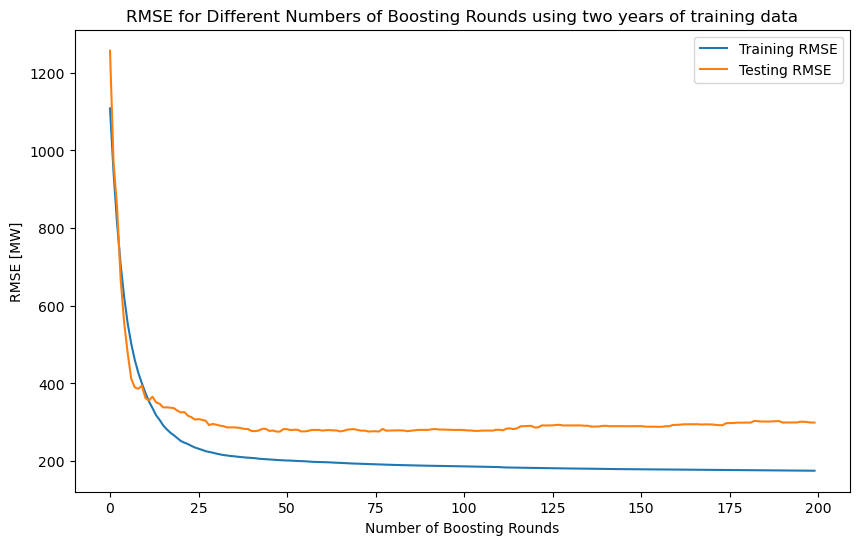

In [33]:
reg_twoyears = xgb.XGBRegressor(base_score=y_train_twoyears.mean(), booster='gbtree',    
                       n_estimators=200,
                       early_stopping_rounds=500,
                       objective='reg:squarederror', 
                       max_depth=3,
                       learning_rate=0.2,
                       reg_alpha=0.1,
                       reg_lambda=0.01,
                       gamma=0,
                       random_state=123)


results = reg_twoyears.fit(X_train_twoyears, y_train_twoyears,
                       eval_set=[(X_train_twoyears, y_train_twoyears), (X_test, y_test)],
                       eval_metric="rmse", 
                       verbose=100)

training_rmse_twoyears = results.evals_result()['validation_0']['rmse']
testing_rmse_twoyears = results.evals_result()['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(training_rmse_twoyears, label='Training RMSE')
plt.plot(testing_rmse_twoyears, label='Testing RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE [MW]')
plt.title('RMSE for Different Numbers of Boosting Rounds using two years of training data')
plt.legend()
plt.show()

## Four years of training data

In [ ]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 8,10],
    'n_estimators': [50, 100, 200, 1000],
    'gamma': [0, 0.1,0.5,1,10],
    'learning_rate': [0.001,0.01, 0.1, 0.2],
    'reg_lambda': [0.0, 0.001, 0.01, 0.1],
    'reg_alpha': [0.0, 0.001, 0.01, 0.1]
}
reg = xgb.XGBRegressor(
    base_score=y_train_fouryears.mean(),
    booster='gbtree',
    objective='reg:squarederror',
    random_state=123
)

grid_search = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv=5,  
    verbose=2,
    n_jobs=-1  
)

grid_search.fit(X_train_fouryears, y_train_fouryears, eval_set=[(X_test, y_test)], early_stopping_rounds=500, verbose=100)

optimal_params = grid_search.best_params_
print("Optimal Hyperparameters:", optimal_params)

optimal_model = grid_search.best_estimator_

y_pred = optimal_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on Test Set:", rmse)


[0]	validation_0-rmse:1165.60628	validation_1-rmse:1371.96040
[100]	validation_0-rmse:222.52491	validation_1-rmse:353.67072


C:\Users\linag\anaconda3\Lib\site-packages\xgboost\sklearn.py:885: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[200]	validation_0-rmse:204.70652	validation_1-rmse:343.01314
[300]	validation_0-rmse:198.63488	validation_1-rmse:327.87658
[400]	validation_0-rmse:194.68194	validation_1-rmse:317.96424
[500]	validation_0-rmse:191.71921	validation_1-rmse:296.13350
[600]	validation_0-rmse:189.51775	validation_1-rmse:299.66165
[700]	validation_0-rmse:187.45340	validation_1-rmse:307.17722
[800]	validation_0-rmse:185.78638	validation_1-rmse:311.71071
[900]	validation_0-rmse:184.01203	validation_1-rmse:289.81433
[999]	validation_0-rmse:182.74762	validation_1-rmse:289.20446


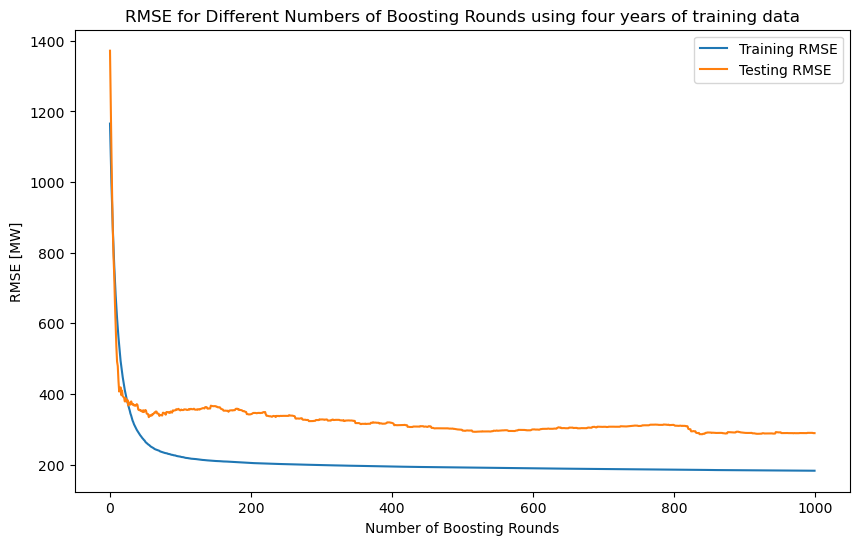

In [31]:
reg_fouryears = xgb.XGBRegressor(base_score=y_train_fouryears.mean(), booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=500,
                       objective='reg:squarederror',  
                       max_depth=3,
                       learning_rate=0.1,
                       reg_alpha=0.0,
                       reg_lambda=0.1,
                       gamma=0,
                       random_state=123)


results = reg_fouryears.fit(X_train_fouryears, y_train_fouryears,
                       eval_set=[(X_train_fouryears, y_train_fouryears), (X_test, y_test)],
                       eval_metric="rmse",  
                       verbose=100)

# Extracting training and testing RMSE from the results
training_rmse_fouryears = results.evals_result()['validation_0']['rmse']
testing_rmse_fouryears = results.evals_result()['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(training_rmse_fouryears, label='Training RMSE')
plt.plot(testing_rmse_fouryears, label='Testing RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.ylabel('RMSE [MW]')
plt.title('RMSE for Different Numbers of Boosting Rounds using four years of training data')
plt.legend()
plt.show()